In [1]:
from setup import *
from scipy.optimize import fsolve
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [2]:
def solve_alpha_s(Te, Tm, alpha_0):
    return np.max(fsolve(lambda alpha_s : alpha_0 - alpha_s*np.exp(-1/2*(1 + alpha_s)/(1 + Te/Tm*alpha_s)*(1 - Te/Tm)) \
            ,np.logspace(-4, 2, 7)))

In [33]:
def cylindrical_sheath_test(uB, J, V):
    R = 200*PROBE_RADIUS
    r_list = np.linspace(R, PROBE_RADIUS, 10000)
    def fun2(y, r):
        return [R*J/(r*EPSILON_0*y[1]) - y[0]/r, ELECTRON_CHARGE*y[0]/(POSITIVE_ION_MASS*y[1])]   # y는 E, u 로 이루어져있음

    sol = odeint(fun2, y0=[0, uB], t=r_list)  # Sheath edge로 추정되는 부분에서 적분 시작
    u = sol[:, 1]
    E = sol[:, 0]
    Va = np.sqrt(2*ELECTRON_CHARGE*V/POSITIVE_ION_MASS)
    f_linear = interp1d(u, r_list)
    return u,E,r_list,R - f_linear(Va)
    #return u,E,r_list,Va

In [40]:
u,E,r_list,r_sh=cylindrical_sheath_test(0.01,10,0.01)

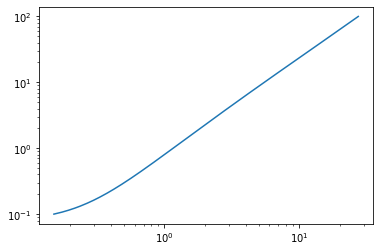

In [39]:
V_list = np.logspace(-1,2,200)
sheath_list = []
for V in V_list:
    _,_,_,r_sh = cylindrical_sheath_test(340,10,V)
    sheath_list.append(r_sh/PROBE_RADIUS)
sheath_list = np.array(sheath_list)

plt.plot(sheath_list, V_list)
plt.xscale('log')
plt.yscale('log')

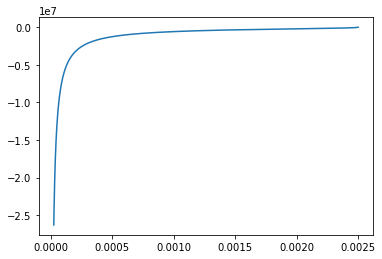

In [17]:
plt.plot(r_list, E)

-0.00023815897854760626


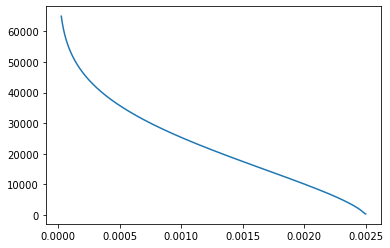

In [18]:
plt.plot(r_list, u)
print(r_sh)

In [ ]:
plt.plot(sh)

In [12]:
def cylindrical_sheath(uB, J, V):
    R = 20*PROBE_RADIUS
    r_list = np.linspace(R, PROBE_RADIUS, 20000)
    def fun(y, r):
        return [R*J/(r*EPSILON_0*y[1]) - y[0]/r, ELECTRON_CHARGE*y[0]/(POSITIVE_ION_MASS*y[1])]   # y는 E, u 로 이루어져있음

    sol = odeint(fun, y0=[0, uB], t=r_list)  # Sheath edge로 추정되는 부분에서 적분 시작
    u = sol[:, 1]
    
    r_sh = r_list[find_nearest(u, np.sqrt(2*ELECTRON_CHARGE*V/(POSITIVE_ION_MASS)))]
    return r_sh

In [13]:
def planar_sheath(uB, J, V):
    r_sh = np.sqrt(4/9*EPSILON_0*np.sqrt(2*ELECTRON_CHARGE/ELECTRON_MASS)*(abs(V))**1.5/J)
    return r_sh


In [14]:
def solve_Seff(V, n_e, n_m, Te, Tm, Vp, cylindrical=True):
    n_p = n_e + n_m
    a_s = solve_alpha_s(Te, Tm, n_m/n_e)
    uBp = np.sqrt(ELECTRON_CHARGE*Te/POSITIVE_ION_MASS)*np.sqrt((1+a_s)/(1+Te/Tm*a_s))
    J = H_FACTOR*n_p*ELECTRON_CHARGE*uBp

    if cylindrical:
        r_sh = cylindrical_sheath(uBp, J, abs(V-Vp)) #r_sh calculation with cylindrical probe
    else:
        r_sh = planar_sheath(uBp, J, abs(V-Vp)) #r_sh calculation with planar probe

    return 2*np.pi*r_sh*PROBE_LENGTH + 2*np.pi*r_sh**2